# Акустические модели

Акустическая модель - это часть системы автоматического распознавания речи, которая используется для преобразования аудиосигнала речи в последовательность фонем или других единиц речевого звука. Акустическая модель обучается на большом наборе речевых данных, чтобы определить, какие звуки соответствуют конкретным акустическим признакам в аудиосигнале. Эта модель может использоваться вместе с другими компонентами, такими как языковая модель и модель декодирования, чтобы достичь более точного распознавания речи.

В данной работе мы сконцентрируемся на обучении нейросетевых акустических моделей с помощью библиотек torch и torchaudio. Для экспериментов будем использовать базу [TIMIT](https://catalog.ldc.upenn.edu/LDC93s1)

#### Запуск виртуального окружения
cd c:\users\user\study\asr\
conda activate asr
jupyter notebook

In [15]:
#pip3.11 install soundfile
#pip3.11 install pandas
#pip3.11 install tqdm
#pip3.11 install torch torchvision torchaudio
#pip3.11 install matplotlib

In [1]:
import numpy as np
import time
import torch
import os
from typing import List, Dict, Union, Set, Any
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchaudio.transforms import MelSpectrogram
from collections import defaultdict, Counter
from pathlib import Path
import pandas as pd
import soundfile as sf
import torchaudio
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

# Загрузка датасета TIMIT

Официальная страница датасета TIMIT 

Для простоты загрузки данных удобнее всего пользоваться копией датасета, выложенной на kaggle 

https://www.kaggle.com/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech


In [2]:
# Торрет-ссылка на скачивание датасета: https://academictorrents.com/download/34e2b78745138186976cbc27939b1b34d18bd5b3.torrent
path = 'timit/data/'      # Корневая рабочая папка датасета
print(os.listdir(path))

['DOC', 'README.DOC', 'TEST', 'TRAIN']


# 1. Подготовка данных для обучения

TIMIT является одной из самых широко используемых баз данных для изучения систем автоматического распознавания речи. База данных TIMIT содержит произнесения предложений различными дикторами. Каждое произнесение сопровождается его словной и фонетической разметкой.

Для обучения акустической модели нам в первую очередь интересна фонетическая разметка произнесений. Такая разметка сопоставляет фонемы, которые были произнесены диктором, с временными интервалами в записи. Такая разметка позволит нам обучить пофреймовый классификатор, который будет предсказывать сказанную фонему.

## 1.a. Загрузка базы с диска

In [3]:
class TimitDataset(Dataset):
    """Загрузка TIMIT данных с диска"""
    def __init__(self, data_path):
        self.data_path = data_path
        self.uri2wav = {}
        self.uri2text = {}
        self.uri2word_ali = {}
        self.uri2phone_ali = {}
        for d, _, fs in os.walk(data_path):
            for f in fs:
                full_path = f'{d}/{f}'
                if f.endswith('.WAV'):
                    stem = Path(f[:-4]).stem # .WAV.wav
                    self.uri2wav[f'{d}/{stem}'] = full_path
                elif f.endswith('.TXT'):
                    stem = Path(f).stem
                    self.uri2text[f'{d}/{stem}'] = full_path
                elif f.endswith('.WRD'):
                    stem = Path(f).stem
                    self.uri2word_ali[f'{d}/{stem}'] = full_path
                elif f.endswith('.PHN'):
                    stem = Path(f).stem
                    self.uri2phone_ali[f'{d}/{stem}'] = full_path
                else:
                    warnings.warn(f"Unknown file type {full_path} . Skip it.")
        
        self.uris = list(sorted(set(self.uri2wav.keys()) \
                              & set(self.uri2text.keys()) \
                              & set(self.uri2word_ali.keys()) \
                              &  set(self.uri2phone_ali.keys())
                               ))
        print(f"Found {len(self.uris)} utterances in {self.data_path}. ", 
              f"{len(self.uri2wav)} wavs, ", 
              f"{len(self.uri2text)} texts, ",
              f"{len(self.uri2word_ali)} word alinments, ",
              f"{len(self.uri2phone_ali)} phone alignments")
    
    def get_uri(self, index_or_uri: Union[str, int]):
        if isinstance(index_or_uri, str):
            uri = index_or_uri
        else:
            uri = self.uris[index_or_uri]
        return uri
    
    def get_audio(self, index_or_uri: Union[str, int]):
        uri = self.get_uri(index_or_uri)
        wav_path = self.uri2wav[uri]
        wav_channels, sr = torchaudio.load(wav_path)
        return wav_channels[0], sr 
        
    def get_text(self, index_or_uri: Union[str, int]):
        """ Return (start_sample, stop_sample, text)"""
        uri = self.get_uri(index_or_uri)
        txt_path = self.uri2text[uri]
        with open(txt_path) as f:
            start, stop, text = f.read().strip().split(maxsplit=2)
            start, stop = int(start), int(stop)
            assert start == 0, f"{txt_path}"
        return start, stop, text
    
    def get_word_ali(self, index_or_uri):
        """ Return [(start_sample, stop_sample, word), ...]"""
        uri = self.get_uri(index_or_uri)
        wrd_path = self.uri2word_ali[uri]
        with open(wrd_path) as f:
            words = [(int(start), int(stop), word) for start, stop, word in map(str.split, f.readlines())]
        return words
    
    def get_phone_ali(self, index_or_uri):
        """ Return [(start_sample, stop_sample, phone), ...]"""
        uri = self.get_uri(index_or_uri)
        ph_path = self.uri2phone_ali[uri]
        with open(ph_path) as f:
            phonemes = [(int(start), int(stop), ph) for start, stop, ph in map(str.split, f.readlines())]
        return phonemes
    
    def __getitem__(self, index):
        return {"uri": self.get_uri(index),
                "audio": self.get_audio(index),
                "text": self.get_text(index),
                "word_ali": self.get_word_ali(index),
                "phone_ali": self.get_phone_ali(index)}       

    def __len__(self): # Возвращаем количество элементов в выборке
        return len(self.uris)

    def total_audio_samples(self) -> int: # Возвращаем суммарное количество отсчетов во всем аудио
        total_number = 0
        for i in self.uris:
            x, _ = self.get_audio(i)
            total_number += x.shape[0]
        return total_number

    def total_num_words(self) -> int: # Возвращаем суммарное количество слов в словном выравнивании
        total_number = 0
        for i in self.uris:
            total_number += len(self.get_word_ali(i))
        return total_number
    
    def total_num_phones(self) -> int: # Возвращаем суммарное количество фонем в фонемном выравнивании
        total_number = 0
        for i in self.uris:
            total_number += len(self.get_phone_ali(i))
        return total_number
    
    def get_vocab(self) -> Set[str]: # Возвращаем словарь, состоящий из уникальных слов из выборки
        x = set()
        for i in self.uris:
            x.update([j for _, _, j in self.get_word_ali(i)])
        return x

    def get_phones(self) -> Set[str]: # Возвращаем уникальный набор фонем, которые используются в выравнивании
        x = set()
        for i in self.uris:
            x.update([j for _, _, j in self.get_phone_ali(i)])
        return x

    def phones_prior(self) -> Dict[str, float]: # Возвращаем мапинг фонемы в их априорные вероятности
        x = Counter()
        for i in self.uris:
            x.update([j for _, _, j in self.get_phone_ali(i)])
        y = sum(x.values())
        return {i: k / y for i, k in x.items()}

In [32]:
test_ds = TimitDataset(path + 'TEST/')

print(f"""
    __len__()           => {len(test_ds)} / 1680
    total_audio_samples => {test_ds.total_audio_samples()} / 82986452
    total_num_words     => {test_ds.total_num_words()} / 14553
    total_num_phones    => {test_ds.total_num_phones()} / 64145
    get_vocab           => {len(test_ds.get_vocab())} / 2378
    get_phones          => {len(test_ds.get_phones())} / 61
    phones_prior        => {len(test_ds.phones_prior())}
""")

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments

    __len__()           => 1680 / 1680
    total_audio_samples => 82986452 / 82986452
    total_num_words     => 14553 / 14553
    total_num_phones    => 64145 / 64145
    get_vocab           => 2378 / 2378
    get_phones          => 61 / 61
    phones_prior        => 61



In [35]:
def test_timit_dataset_stats():
    test_ds = TimitDataset(path + 'TEST/')

    print("Len")
    assert len(test_ds) == 1680, f"{len(test_ds)}"

    print("Audio")
    audio_len = test_ds.total_audio_samples()
    assert audio_len == 82986452, f"{audio_len}"

    print("Words")
    words_len = test_ds.total_num_words()
    assert words_len == 14553, f"{words_len}"

    print("Phones")
    phones_len = test_ds.total_num_phones()
    assert phones_len == 64145, f"{phones_len}"

    print("Vocab")
    vocab = test_ds.get_vocab()
    assert len(set(vocab)) == 2378, f"{len(set(vocab))}"

    print("Phones vocab")
    phones = test_ds.get_phones()
    assert len(set(phones)) == 61, f"{len(set(phones))}"
    
    print("Phones prior")
    priors = test_ds.phones_prior()
    assert np.isclose(sum(priors.values()), 1.0), f"sum(priors.values())"
    pmin, pmax = min(priors.keys(), key=priors.get), max(priors.keys(), key=priors.get)
    assert pmin == 'eng', pmin
    assert pmax == 'h#', pmax
    print("Test 1.a passed")
test_timit_dataset_stats()

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
Len
Audio
Words
Phones
Vocab
Phones vocab
Phones prior
Test 1.a passed


In [36]:
test_ds = TimitDataset(path + 'TEST/')
item = test_ds[5]
print(item['uri'])
print(item['text'][2])
display.display(display.Audio(item['audio'][0].numpy(), rate=item['audio'][1]))
print('---words---')
for start, stop, word in item['word_ali']:
    print(word)
    display.display(display.Audio(item['audio'][0][start:stop].numpy(), rate=item['audio'][1]))
    break

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
timit/data/TEST/DR1\FAKS0/SX133
Pizzerias are convenient for a quick lunch.


---words---
pizzerias


## 1.b. Экстрактор фич
Для того чтобы построить акустическую модель, первым делом надо извлечь признаки аудио сигнала. Для распознавания речь принято использовать fbank признаки. fbank/MelSpectrogram признаки получается из амплитудного спектра сигнала путем свертки спекта с треугольными фильтрами в мел-шкале. Есть множество реализаций данных признаков в различных библиотеках (kaldi, librosa, torchaudio) и все они имеют свои особенности. В данной работе мы будем использовать реализацию из библиотеки torchaudio. 

In [4]:
class FeatureExtractor(torch.nn.Module):
    def __init__(
        self,
        sample_rate=16000,
        n_fft=400,
        hop_length=160,
        n_mels=40,
        f_max=7600,
        spec_aug_max_fmask=80,
        spec_aug_max_tmask=80,
    ):
        super().__init__()
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels

        # инициализация обработчика fbank фич из torchaudio
        self.mel_spec = MelSpectrogram(
            sample_rate=self.sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels,
            f_max=f_max)
        
    def samples2frames(self, num_samples: int) -> int: # Возвращает количество кадров в спектрограмме, соответствующей вавке длиной num_samples
     return (num_samples // self.hop_length) + 1
    
    @property
    def feats_dim(self): # Возвращает количество извлекаемых фич
        return self.n_mels
    
    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        return self.mel_spec(waveform)

In [40]:
def test_samples2frames():
    fe = FeatureExtractor()
    for i in tqdm(range(15000, 40000)):
        wav = torch.zeros(i)
        feats = fe(wav)
        assert feats.shape[-2] == fe.feats_dim, f"{i} {feats.shape[-2]=}, {fe.feats_dim}"

        assert feats.shape[-1] == fe.samples2frames(i), f"{i} {feats.shape[-1]=}, {fe.samples2frames(i)}"
        
    print('Test 1.b passed')
test_samples2frames()

  0%|          | 0/25000 [00:00<?, ?it/s]

Test 1.b passed


## 1.с. Таргеты и объединение данных в батчи 

Акустическая Модель (АМ) - пофреймовый классификатор, который предсказывает фонему для каждого кадра аудио. Для обучения AM будем использовать фонемное выравнивание. 

In [5]:
train_ds = TimitDataset(path + 'TRAIN/')
print(train_ds[0])

# Строим мапинг из написания фонемы в ее id 
phones = train_ds.get_phones() 
phones.remove('pau')
phones.remove('epi')
phones.remove('h#')

# Фонемы паузы должны иметь индекс 0
PHONE2ID = {p:i for i, p in enumerate(['pau'] + list(sorted(phones)))}
PHONE2ID['epi'] = 0
PHONE2ID['h#'] = 0
print(PHONE2ID)

Found 4620 utterances in timit/data/TRAIN/.  4620 wavs,  4620 texts,  4620 word alinments,  4620 phone alignments
{'uri': 'timit/data/TRAIN/DR1\\FCJF0/SA1', 'audio': (tensor([ 3.0518e-05, -3.0518e-05,  6.1035e-05,  ..., -3.0518e-05,
        -1.5259e-04, -2.4414e-04]), 16000), 'text': (0, 46797, 'She had your dark suit in greasy wash water all year.'), 'word_ali': [(3050, 5723, 'she'), (5723, 10337, 'had'), (9190, 11517, 'your'), (11517, 16334, 'dark'), (16334, 21199, 'suit'), (21199, 22560, 'in'), (22560, 28064, 'greasy'), (28064, 33360, 'wash'), (33754, 37556, 'water'), (37556, 40313, 'all'), (40313, 44586, 'year')], 'phone_ali': [(0, 3050, 'h#'), (3050, 4559, 'sh'), (4559, 5723, 'ix'), (5723, 6642, 'hv'), (6642, 8772, 'eh'), (8772, 9190, 'dcl'), (9190, 10337, 'jh'), (10337, 11517, 'ih'), (11517, 12500, 'dcl'), (12500, 12640, 'd'), (12640, 14714, 'ah'), (14714, 15870, 'kcl'), (15870, 16334, 'k'), (16334, 18088, 's'), (18088, 20417, 'ux'), (20417, 21199, 'q'), (21199, 22560, 'en'), (22

In [6]:
class FeatsPhoneDataset(TimitDataset):
    def __init__(self, data_path, feature_extractor: FeatureExtractor, phone2id):
        super().__init__(data_path)
        self.feature_extractor = feature_extractor
        self.phone2id = phone2id
    
    def __getitem__(self, index):
        orig_item = super().__getitem__(index)
        wav, sr = orig_item['audio']
        assert sr == self.feature_extractor.sample_rate, f"wrong sr for {index}"
        
        # подготавливаем пофреймовые фичи
        feats = self.feature_extractor(wav)
        feats = feats.squeeze(dim=0).transpose(0, 1) # time x feats

        # создаем пофреймовое выравнивание 
        targets = torch.zeros(feats.shape[0], dtype=torch.long)

        # заполняем пофреймовое фонемное выравнивание targets idшниками фонем
        for start, stop, phone in orig_item['phone_ali']:
            # Преобразуем временные интервалы в интервалы кадров
            start_frame = self.feature_extractor.samples2frames(start)
            stop_frame = self.feature_extractor.samples2frames(stop)
            targets[start_frame:stop_frame] = self.phone2id[phone]
    
        return {"uri": orig_item["uri"],
                "feats": feats,
                "targets": targets,
                "src_key_padding_mask": torch.zeros(feats.shape[0], dtype=torch.bool)}

    
    def collate_pad(self, batch: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        """Функция объединения элементов в один батч"""
        feats = pad_sequence([i['feats'] for i in batch], batch_first = True)  # Batch, Time, Feats
        feats = feats.transpose(0, 1)  # Time, Batch, Feats
    
        targets = torch.cat([i['targets'] for i in batch])  # SumTime
    
        lengths = torch.tensor([i.shape[0] for i in [item['feats'] for item in batch]], dtype = torch.long)
        src_key_padding_mask = torch.arange(lengths.max())[None, :] >= lengths[:, None]  # Batch, Time

        return {'feats': feats, # Time, Batch, feats
               'targets': targets, # SumTime
               'src_key_padding_mask': src_key_padding_mask, # Batch, Time
               }

In [62]:
def test_collate_pad():
    fe = FeatureExtractor()
    test_ds = FeatsPhoneDataset(path + 'TEST/', feature_extractor=fe, phone2id=PHONE2ID)

    for i in range(20):
        targets = test_ds[i]['targets']
        orig_ph_ali = test_ds.get_phone_ali(i)
        targets_set = set(targets.tolist())
        orig_set = set([PHONE2ID[ph] for *_, ph in orig_ph_ali])
        assert targets_set == orig_set, f"{i} \n{targets_set} \n {orig_set} \n {orig_ph_ali}"

    items = [test_ds[i] for i in range(30)]
    batch = test_ds.collate_pad(items)
    assert len(batch['feats'].shape) == 3, batch['feats'].shape
    assert batch['feats'].shape[1] == 30, batch['feats'].shape
    
    assert len(batch['src_key_padding_mask'].shape) == 2, batch['src_key_padding_mask'].shape
    assert batch['src_key_padding_mask'].shape[0] == 30, batch['src_key_padding_mask'].shape
    assert batch['src_key_padding_mask'].shape[1] == batch['feats'].shape[0], f"{batch['feats'].shape} {batch['src_key_padding_mask'].shape}"
    
    number_nonmasked_frames = (~batch['src_key_padding_mask']).sum()
    assert number_nonmasked_frames == len(batch['targets']), f"{number_nonmasked_frames} != {len(batch['targets'])}"

    accumulated_len = 0
    for i, item in enumerate(items):
        feats = batch['feats'][:, i, :]
        assert torch.isclose(feats.sum(), item['feats'].sum()) , i
        src = batch['src_key_padding_mask'][i, :]
        cutted_feats = feats[~src]
        assert torch.isclose(item['feats'], cutted_feats).all()
        cutted_targets = batch['targets'][accumulated_len: accumulated_len + cutted_feats.shape[0]]
        assert torch.isclose(cutted_targets, item['targets']).all()
        accumulated_len += cutted_feats.shape[0]
    print("Test 1.c passed")
    
test_collate_pad()

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
Test 1.c passed


# 2. Акустическая модель

Обучим TransformerEncoder из torch решать задачу пофреймовой классификации. 

In [7]:
class AModel(nn.Module):
    def __init__(self, feats_dim, out_dim,  dim=128, num_layers=4, ff_dim=256, dropout=0.1, nhead=4, max_len=780):
        super().__init__()
        self.feats_dim = feats_dim
        self.max_len=max_len
        self.input_ff = nn.Linear(feats_dim, dim)
        self.positional_encoding = nn.Embedding(max_len, dim)
        layer = torch.nn.TransformerEncoderLayer(d_model=dim, 
                                                 nhead=nhead, 
                                                 dim_feedforward=ff_dim, 
                                                 dropout=dropout, 
                                                 batch_first=False)
        self.encoder = torch.nn.TransformerEncoder(encoder_layer=layer, num_layers=num_layers)
        
        self.head = nn.Linear(dim, out_dim)

    def forward(self, feats, src_key_padding_mask=None, **kwargs):
        #TODO 
        # реализуйте прямой проход модели.
        # Фичи подаются на первый ff слой, 
        # к результату прибавляются позиционные эмбединги.
        # Далее фреймы обрабатываются трансформером 
        # и финализируются с помощью головы
        
        # Обработка через первый линейный слой и добавление позиционных эмбеддингов
        enhanced_feats = self.input_ff(feats) + self.positional_encoding(torch.arange(0, feats.size(0), device=feats.device).unsqueeze(1))
    
        # Обработка усиленных признаков через трансформер и голову
        transformed_feats = self.encoder(enhanced_feats, src_key_padding_mask=src_key_padding_mask)
    
        return self.head(transformed_feats) # (Time, Batch, Phones)
        
        #return logits # (Time, Batch, Phones)

## 3. Обучение модели 

In [8]:
# Стандартный пайплайн обучения моделей в pytorch
class Trainer(nn.Module):
    def __init__(self, model, fe, phone2id, device='cuda', opt_cls=torch.optim.Adam, opt_kwargs={'lr':0.0001}):
        super().__init__()
        self.device=device
        self.fe = fe
        self.model = model.to(self.device)
        self.phone2id = phone2id
        self.id2phone = {i:ph for ph,i in phone2id.items()}
        self.optimizer = opt_cls(self.model.parameters(), **opt_kwargs)
        self.criterion = torch.nn.CrossEntropyLoss()
        print(f"{self.model}. {self.device}")

    def to(self, device):
        self.device = device
        return super().to()
        
    def forward(self, batch):
        batch = self.batch_to_device(batch)
        logits = self.model(**batch)
        # TODO
        # реализуйте подсчет loss функции  
        # Переносим данные батча на нужное устройство
    
        # Форматируем и фильтруем логиты с учетом маски паддинга
        reshaped_logits = logits.permute(1, 0, 2).reshape(-1, logits.size(-1))[~batch['src_key_padding_mask'].view(-1)]
        
        # Вычисляем потери с использованием кросс-энтропии
        loss = self.criterion(reshaped_logits, batch['targets'])
        return loss

    def batch_to_device(self, batch):
        return {k: v.to(self.device) for k, v in batch.items()}
        
    def train_one_epoch(self, train_dataloader):
        """ Цикл обучения одной эпохи по всем данным"""
        self.model.train()
        pbar = tqdm(train_dataloader)
        losses = []
        for batch in pbar:
            self.optimizer.zero_grad()
            loss = self.forward(batch)
            loss.backward()
            self.optimizer.step()
            losses.append(loss.item())
            pbar.set_description(f"training loss {losses[-1]:.5f}")
        return losses

    def score(self, valid_dataloader) -> List[float]:
        """Подсчет лосса на валидационной выборке"""
        pbar = tqdm(valid_dataloader, desc="Scoring...")
        losses = []
        # TODO 
        # реализуйте функцию, которая подсчитывает лосс на валидационной выборке 
        # losses должен хранить значение ошибки на каждом батче 
        
        #self.model.eval()
        #for data_batch in tqdm(valid_dataloader, desc="Validation"):
        #    with torch.no_grad():
        #        validation_loss = self.forward(data_batch).item()
        #        losses.append(validation_loss)
        #        tqdm.write(f"Batch loss: {validation_loss:.5f}")
        self.model.eval()
        losses = []
        with torch.no_grad():
            for data_batch in valid_dataloader:
                validation_loss = self.forward(data_batch).item()
                losses.append(validation_loss)
                
        return losses

    def fit(self, train_dataloader, epochs, valid_dataloader=None, plot_losses=True):
        """Запуск обучения на данном dataloader"""
        pbar = tqdm(range(epochs))
        per_epoch_train_losses = []
        per_epoch_val_losses = []
        for e in pbar:
            train_loss = np.mean(self.train_one_epoch(train_dataloader))
            per_epoch_train_losses.append(train_loss)
            if valid_dataloader is not None:
                val_loss = np.mean(self.score(valid_dataloader))
                per_epoch_val_losses.append(val_loss)
            if plot_losses:
                display.clear_output()
                self.plot_losses(per_epoch_train_losses, per_epoch_val_losses)
            else:
                val_loss = val_loss if valid_dataloader is not None else float('Nan')
                print(f"train: {train_loss:.5f} | val: {val_loss:.5f}")
        return per_epoch_train_losses, per_epoch_val_losses
    
    def plot_losses(self, train_losses, val_losses=[]):
        plt.title(f"Train test losses (epoch {len(train_losses)})")
        plt.plot(range(len(train_losses)), train_losses)
        if len(val_losses)>0:
            assert len(train_losses) == len(val_losses)
            plt.plot(range(len(val_losses)), val_losses)
        plt.ylabel("loss")
        plt.xlabel('epoch')
        plt.legend(["train loss", "valid loss"])
        plt.grid(True)
        plt.show()

Found 10 utterances in timit/data/TEST/DR1/FAKS0.  10 wavs,  10 texts,  10 word alinments,  10 phone alignments
AModel(
  (input_ff): Linear(in_features=40, out_features=256, bias=True)
  (positional_encoding): Embedding(780, 256)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (head): Linear(in_features=256, out_features=59, bias=True)
).

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 4.34180 | val: 4.02688


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 4.03626 | val: 3.81558


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.81895 | val: 3.70185


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.70096 | val: 3.63684


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.63466 | val: 3.57790


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.57582 | val: 3.51705


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.51531 | val: 3.46449


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.46285 | val: 3.42730


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.42543 | val: 3.40171


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.39934 | val: 3.37951


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.37653 | val: 3.35624


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.35270 | val: 3.33234


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.32835 | val: 3.31041


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.30608 | val: 3.29222


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.28765 | val: 3.27691


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.27220 | val: 3.26155


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.25677 | val: 3.24358


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.23881 | val: 3.22283


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.21817 | val: 3.20113


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.19662 | val: 3.18031


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.17594 | val: 3.16069


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.15648 | val: 3.14103


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.13703 | val: 3.11965


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.11588 | val: 3.09581


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.09232 | val: 3.07027


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.06706 | val: 3.04445


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.04150 | val: 3.01907


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.01632 | val: 2.99343


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.99078 | val: 2.96636


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.96369 | val: 2.93773


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.93490 | val: 2.90844


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.90539 | val: 2.87927


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.87597 | val: 2.85007


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.84656 | val: 2.82033


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.81665 | val: 2.79020


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.78646 | val: 2.76043


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.75672 | val: 2.73106


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.72748 | val: 2.70163


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.69822 | val: 2.67225


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.66903 | val: 2.64329


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.64026 | val: 2.61447


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.61152 | val: 2.58527


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.58234 | val: 2.55599


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.55310 | val: 2.52702


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.52431 | val: 2.49785


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.49543 | val: 2.46817


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.46606 | val: 2.43872


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.43691 | val: 2.40984


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.40835 | val: 2.38116


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.38000 | val: 2.35276


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.35192 | val: 2.32483


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.32428 | val: 2.29719


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.29693 | val: 2.26990


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.26998 | val: 2.24293


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.24341 | val: 2.21601


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.21690 | val: 2.18932


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.19060 | val: 2.16308


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.16469 | val: 2.13698


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.13886 | val: 2.11099


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.11308 | val: 2.08535


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.08765 | val: 2.05999


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.06252 | val: 2.03487


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.03763 | val: 2.01003


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.01303 | val: 1.98537


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.98863 | val: 1.96097


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.96448 | val: 1.93685


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.94058 | val: 1.91293


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.91685 | val: 1.88923


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.89332 | val: 1.86554


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.86977 | val: 1.84211


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.84648 | val: 1.81885


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.82335 | val: 1.79572


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.80032 | val: 1.77277


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.77745 | val: 1.74999


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.75472 | val: 1.72734


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.73211 | val: 1.70481


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.70963 | val: 1.68249


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.68736 | val: 1.66035


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.66525 | val: 1.63838


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.64330 | val: 1.61659


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.62151 | val: 1.59497


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.59986 | val: 1.57346


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.57831 | val: 1.55209


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.55689 | val: 1.53086


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.53562 | val: 1.50978


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.51449 | val: 1.48885


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.49350 | val: 1.46810


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.47268 | val: 1.44748


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.45198 | val: 1.42692


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.43135 | val: 1.40640


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.41073 | val: 1.38592


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.39015 | val: 1.36554


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.36968 | val: 1.34525


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.34932 | val: 1.32514


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.32915 | val: 1.30528


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.30926 | val: 1.28559


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.28957 | val: 1.26602


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.26998 | val: 1.24651


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.25046 | val: 1.22707


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.23099 | val: 1.20772


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.21162 | val: 1.18850


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.19237 | val: 1.16937


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.17322 | val: 1.15035


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.15418 | val: 1.13142


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.13525 | val: 1.11261


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.11646 | val: 1.09394


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.09781 | val: 1.07541


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.07929 | val: 1.05704


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.06093 | val: 1.03893


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.04284 | val: 1.02136


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.02529 | val: 1.00525


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.00936 | val: 0.98908


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.99316 | val: 0.97252


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.97682 | val: 0.95066


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.95448 | val: 0.93627


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.94036 | val: 0.92369


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.92790 | val: 0.90037


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.90420 | val: 0.88987


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.89401 | val: 0.87626


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.88064 | val: 0.85400


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.85799 | val: 0.84572


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.85009 | val: 0.82308


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.82704 | val: 0.81165


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.81585 | val: 0.79244


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.79625 | val: 0.78114


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.78530 | val: 0.76480


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.76875 | val: 0.75149


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.75560 | val: 0.73421


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.73790 | val: 0.72265


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.72665 | val: 0.70616


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.70986 | val: 0.69447


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.69838 | val: 0.67698


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.68055 | val: 0.66638


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.67013 | val: 0.64954


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.65316 | val: 0.63887


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.64265 | val: 0.62243


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.62601 | val: 0.61173


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.61551 | val: 0.59594


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.59950 | val: 0.58494


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.58873 | val: 0.57038


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.57393 | val: 0.55892


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.56255 | val: 0.54503


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.54855 | val: 0.53364


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.53722 | val: 0.52067


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.52417 | val: 0.50900


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.51249 | val: 0.49627


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.49967 | val: 0.48500


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.48844 | val: 0.47314


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.47652 | val: 0.46178


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.46517 | val: 0.45038


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.45374 | val: 0.43951


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.44288 | val: 0.42851


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.43183 | val: 0.41774


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.42103 | val: 0.40717


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.41043 | val: 0.39681


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.40005 | val: 0.38682


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.39002 | val: 0.37662


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.37978 | val: 0.36699


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.37015 | val: 0.35729


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.36040 | val: 0.34798


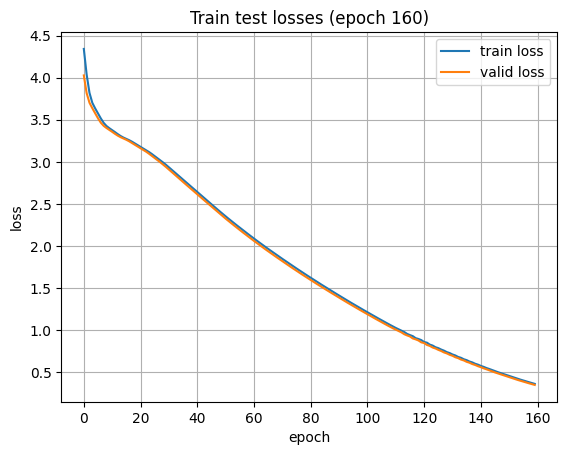

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

Test 3.a passed


In [66]:
def overfit_one_batch_check():
    # Для проверки работоспособности кода обучения удоно использовать тест модели на overfit 
    # Для этого запускается обучение на одном батче данных. 
    # Если код написан правильно, то модель обязана выучить выучить все примеры из этого батча наизусть. 
    fe = FeatureExtractor()
    train_dataset = FeatsPhoneDataset('timit/data/TEST/DR1/FAKS0', feature_extractor=fe, phone2id=PHONE2ID)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, collate_fn=train_dataset.collate_pad)
    test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, collate_fn=train_dataset.collate_pad)

    trainer = Trainer(model=AModel(feats_dim=fe.feats_dim, 
                                   out_dim=max(PHONE2ID.values()) + 1,  
                                   dim=256, 
                                   num_layers=6, 
                                   ff_dim=512, 
                                   dropout=0.0, 
                                   nhead=8), 
                      fe=fe, 
                      phone2id=PHONE2ID, device='cpu')
   
    # only one batch. The model must learn it by heart
    losses, val_losses = trainer.fit(train_dataloader, 160, valid_dataloader=test_dataloader, plot_losses=False)

    trainer.plot_losses(losses, val_losses)

    val_loss = np.mean(trainer.score(test_dataloader))
    
    assert val_loss < 0.5, f"{val_loss}. Model doesn't train well" 
    print(f"Test 3.a passed")
overfit_one_batch_check()

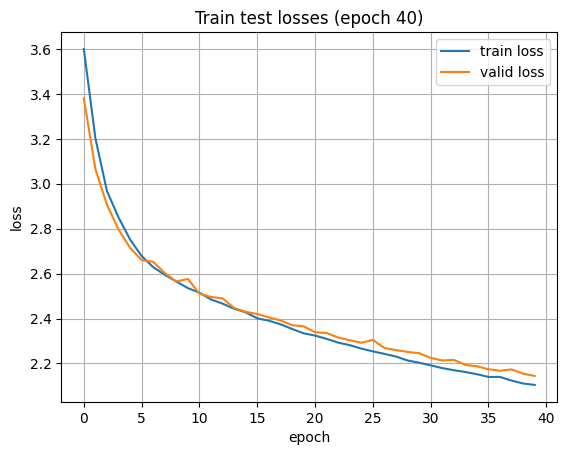

In [68]:

def experiment():
    # Запуск полноценного обучения модели
    # TODO: Тюнинг гиперпараметров
    fe = FeatureExtractor()
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataset = FeatsPhoneDataset('timit/data/TRAIN/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=40, 
                                               num_workers=0, collate_fn=train_dataset.collate_pad, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, 
                                               num_workers=0, collate_fn=test_dataset.collate_pad, shuffle=False)


    trainer = Trainer(model=AModel(feats_dim=fe.feats_dim, 
                                 out_dim=max(PHONE2ID.values())+1, 
                                 dim=128, 
                                 num_layers=7, 
                                 ff_dim=256, 
                                 dropout=0.0, 
                                 nhead=8),
                     fe=fe, 
                     phone2id=PHONE2ID, device='cpu')

    trainer.fit(train_dataloader, epochs=40, valid_dataloader=test_dataloader, plot_losses=True)
    return trainer.to('cpu')
results = experiment()

In [9]:
def experiment(num_epochs = 40, train_batch_size = 40, test_batch_size = 1, num_workers = 0, model_params = None):
    # Запуск полноценного обучения модели
    # TODO: Тюнинг гиперпараметров
    fe = FeatureExtractor()
    test_dataset = FeatsPhoneDataset(path + 'TEST/', feature_extractor = fe, phone2id = PHONE2ID)
    train_dataset = FeatsPhoneDataset(path + 'TRAIN/', feature_extractor = fe, phone2id = PHONE2ID)
    
    train_dataloader =  torch.utils.data.DataLoader(train_dataset,
                                                    batch_size = train_batch_size,
                                                    num_workers = num_workers,
                                                    collate_fn=train_dataset.collate_pad,
                                                    shuffle = True)
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                    batch_size = test_batch_size,
                                                    num_workers = num_workers,
                                                    collate_fn = test_dataset.collate_pad,
                                                    shuffle = False)

    trainer = Trainer(model = AModel(feats_dim = fe.feats_dim, out_dim = max(PHONE2ID.values()) + 1, **model_params),
                      fe=fe, 
                      phone2id = PHONE2ID,
                      device = 'cpu')

    trainer.fit(train_dataloader, epochs = num_epochs, valid_dataloader = test_dataloader, plot_losses = True)
    return trainer.to('cpu')

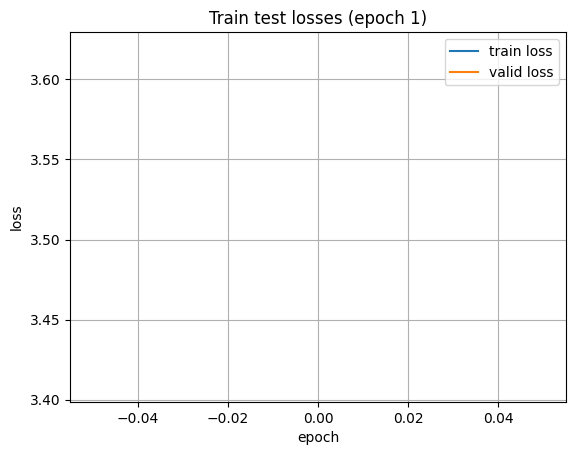

In [10]:
# Запуск эксперимента
model_params = {'dim': 128, 'num_layers': 7, 'ff_dim': 256, 'dropout': 0.0, 'nhead': 8}
results = experiment(num_epochs = 1, train_batch_size = 40, test_batch_size = 1, num_workers = 0, model_params = model_params)

In [11]:
torch.save(results, 'baseline.trainer')

# Основное задание (12 баллов)
Надо улучшить бейзлайн так, чтобы значение loss на валидации было менее 1.9 

**Дополнительное задание** (4 балла): Улучшите loss до 1.4 

In [23]:
def test_trained_model(trainer):
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=trainer.fe, phone2id=trainer.phone2id)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, 
                                               num_workers=0, collate_fn=test_dataset.collate_pad, shuffle=False)
    loss = np.mean(trainer.score(test_dataloader))
    print(f"Test loss is {loss}")
    assert loss < 1.9, "Main task failed"
    print(f"Main task is done! (12 points)")
    if loss <= 1.4:
        print(f"Additional task is done! (+4 points)")
test_trained_model(results.to('cuda'))